# Sentiment Analysis on Yelp Reviews Dataset

## Step 0: Initialize Spark

In [1]:
from pyspark.sql import SparkSession

ss = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()
print("Spark version:", ss.version)

Spark version: 3.5.1


## Step 1: Import Libraries and Functions

In [ ]:
import os

# PySpark Core
from pyspark.sql.functions import when

# PySpark ML
from pyspark.ml.classification import LogisticRegressionModel, LinearSVCModel, NaiveBayesModel
from pyspark.ml import PipelineModel

In [42]:
# Functions from scripts
from model_utils.spark_metrics_utils import print_metrics, confusion_matrix
from model_utils.model_utils import save_model
from utils.table_utils import plot_dict_highlight_max
from utils.time_utils import print_from_seconds_to_hours
from utils.io_utils import save_dict, load_dict
from pipelines import logistic_regression, naive_bayes, linear_svc
from final_model.final_model import train_final_model, run_prediction

In [4]:
# google colab
from utils.colab_utils import zip_and_download

In [5]:
scores_filename = 'scores.json'
models_path = 'models'

## Step 1: Download the dataset

In [6]:
# setup Kaggle API in google colab

from google.colab import files
import shutil
import os

kaggle = files.upload() # Upload kaggle.json manually
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
 99% 4.04G/4.07G [00:53<00:00, 107MB/s] 
100% 4.07G/4.07G [00:54<00:00, 79.6MB/s]


In [8]:
!unzip yelp-dataset.zip

Archive:  yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


## Step 3: Load the dataset

In [9]:
yelp_df = ss.read.json("yelp_academic_dataset_review.json")

# store as Parquet for better performance and compression
yelp_df.write.mode("overwrite").parquet("yelp_parquet")
yelp_df = ss.read.parquet("yelp_parquet")
yelp_df.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|znK6tMeegKf9YnGut...|   0|2021-04-16 22:02:21|    0|MmmrqbdupYBJq9jnl...|  5.0|Great little spot...|     0|TjD2S66AWxlKsPSQB...|
|UxwpCVLgPWCeaRyet...|   0|2021-01-03 21:54:48|    0|1_uWX0bBJNnZjPEcp...|  5.0|James was super k...|     0|Vtfxxq3nxdYHRiH6O...|
|eVI64EQymywsvMLmD...|   0|2020-11-01 19:50:03|    0|WVAEE47MnM3Sv2cvM...|  5.0|By far the best i...|     0|ZDw_qN5Fy6PE0gdbV...|
|SPcPJfPgWzhjUDqVF...|   0|2021-03-24 05:53:49|    0|D5b6iooZZcJ8nG-9P...|  5.0|I thought that th...|     0|UvMDlX2wV4Md9OwGW...|
|T5XzQ6YnVExvd0BOR...|   0|2016-06-13 21:25:10|    0|uDxnT7zWFnxEDxp5e...|  5.0|Aside from

 ## Step 4: Inspect the Dataset

In [10]:
print("Number of columns:", len(yelp_df.columns))
print("Number of reviews:", yelp_df.count())

Number of columns: 9
Number of reviews: 6990280


In [11]:
yelp_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [12]:
data_df = yelp_df.select(["text", "stars"])
data_df.show(5)

+--------------------+-----+
|                text|stars|
+--------------------+-----+
|Great little spot...|  5.0|
|James was super k...|  5.0|
|By far the best i...|  5.0|
|I thought that th...|  5.0|
|Aside from the re...|  5.0|
+--------------------+-----+
only showing top 5 rows



## Step 5: Data Labeling / Preparing for Modeling

In [13]:
data_df = data_df.filter("stars!=3.0")
data_df = data_df.withColumn("label", when(data_df["stars"]>=3.5, 1).otherwise(0))

data_df.show(5)

+--------------------+-----+-----+
|                text|stars|label|
+--------------------+-----+-----+
|Great little spot...|  5.0|    1|
|James was super k...|  5.0|    1|
|By far the best i...|  5.0|    1|
|I thought that th...|  5.0|    1|
|Aside from the re...|  5.0|    1|
+--------------------+-----+-----+
only showing top 5 rows



## Step 6: Sample a subset of the data

In [14]:
subreviews_df = data_df.sample(False, 0.01, seed=0)
print("Number of reviews in subreviews dataframe: %d" % subreviews_df.count())

Number of reviews in subreviews dataframe: 62907


## Step 7: Split Data into Training and Test Sets

In [15]:
train_df, test_df = subreviews_df.randomSplit([0.7, 0.3])

## Step 8: Model Comparison and Evaluation

### Logistic Regression

In [17]:
lr_results = logistic_regression.run_lr(train_df, test_df)

save_dict(scores_filename, {"Logistic Regression": lr_results["f1_score"]})
save_model(lr_results["model"], models_path, 'lr_model')

Total time:  2h 25m 18s


### Naive Bayes

In [18]:
nb_results = naive_bayes.run_nb(train_df, test_df)

save_dict(scores_filename, {"Naive Bayes": nb_results["f1_score"]})
save_model(nb_results["model"], models_path, 'nb_model')

Total time:  0h 20m 14s


### Linear SVC

In [19]:
svc_results = linear_svc.run_linear_svc(train_df, test_df)

save_dict(scores_filename, {"Linear SVC": svc_results["f1_score"]})
save_model(svc_results["model"], models_path, 'svc_model')

Total time:  3h 23m 30s


### Evaluation

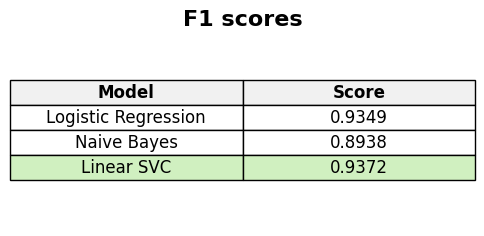

In [20]:
f1_scores = load_dict(scores_filename)
plot_dict_highlight_max(f1_scores, title="F1 scores", col_label="Model", val_label="Score")

In [25]:
# download from google colab
zip_and_download("models/lr_model")
zip_and_download("models/nb_model")
zip_and_download("models/svc_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
selected_model = "svc"

## Step 12: Final Training and Testing on the Full Dataset

In [15]:
train_df, test_df = data_df.randomSplit([0.9, 0.1])

In [16]:
if selected_model=="lr":
    lr_model = LogisticRegressionModel.load("models/lr_model")
    best_params = {"regParam": lr_model._java_obj.getRegParam(),
                    "elasticNetParam": lr_model._java_obj.getElasticNetParam()}
elif selected_model=="nb":
    nb_model = NaiveBayesModel.load("models/nb_model")
    best_params = {"smoothing": nb_model._java_obj.getSmoothing()}
elif selected_model=="svc":
    svc_model = LinearSVCModel.load("models/svc_model")
    best_params = {"regParam": svc_model._java_obj.getRegParam(),
                    "maxIter": svc_model._java_obj.getMaxIter()}
else:
    raise ValueError(f"Unsupported model type: '{selected_model}'")

In [17]:
model, metrics, preprocessing_model = train_final_model(train_df, test_df, best_params, selected_model)

save_model(preprocessing_model, models_path, 'preprocessing_model')
save_model(model, models_path, 'final_model')

#preprocessing_model.write().overwrite().save("models/preprocessing_model")

Total preprocessing:  1h 30m 28s
Total training:  3h 11m 53s


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [18]:
print_metrics(metrics)

       Metric    Score
     Accuracy 0.948431
Precision (0) 0.873725
Precision (1) 0.976492
   Recall (0) 0.933158
   Recall (1) 0.953677
       F1 (0) 0.902464
       F1 (1) 0.964950
  Weighted F1 0.948975


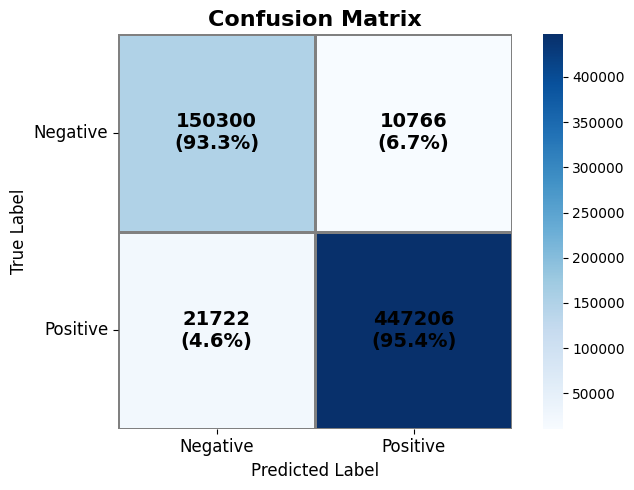

In [19]:
confusion_matrix(metrics)

In [ ]:
# download the model from google colab
zip_and_download("models/preprocessing_model")
zip_and_download("models/final_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 13: Predict Sentiment on Custom Reviews

In [ ]:
selected_model="svc"
final_model_path=os.path.join(model_path, "final_model")
preprocessing_model_path=os.path.join(model_path, "preprocessing_model")

In [44]:
reviews = [ "Great food!",
    "Terrible service, will not return.",
    "The atmosphere was cozy and the staff was super friendly. Food was delicious and arrived on time.",
    "I waited 45 minutes for my meal and the waiter was rude. The food was cold when it finally came.",
    "I had an amazing dinner at this restaurant last night. The appetizers were flavorful, the main course was cooked perfectly, and the dessert was heavenly. Highly recommend it for anyone looking for a great dining experience!",
    "This place was a huge disappointment. We waited forever to get seated, the service was inattentive, and the food lacked any real flavor. To make matters worse, the restaurant was noisy and uncomfortable. Definitely not coming back.",
    "Visited this restaurant twice last month. The first time the food was excellent, but the service was slow. On my second visit, the service improved but the food was just okay. The ambiance is nice though, so I might give it another shot sometime.",
    "It was okay.",
    "Loved the place! 🍕 The pizza was amazing and the staff was very welcoming.",
    "Not impressed 😞. The pasta was overcooked and the waiter forgot our drinks."
]


In [45]:
run_prediction(
    text_list=reviews,
    selected_model=selected_model,
    preprocessing_model_path=preprocessing_model_path,
    final_model_path=final_model_path,
    spark_session=ss
)

+--------------------+--------------------+----------+
|                text|       rawPrediction|prediction|
+--------------------+--------------------+----------+
|         Great food!|[-0.3449430174876...|       1.0|
|Terrible service,...|[0.55482429873258...|       0.0|
|The atmosphere wa...|[-1.1644249313589...|       1.0|
|I waited 45 minut...|[1.01637447999566...|       0.0|
|I had an amazing ...|[-1.7037260207235...|       1.0|
|This place was a ...|[1.89412024329983...|       0.0|
|Visited this rest...|[0.22562034914535...|       0.0|
|        It was okay.|[0.28191814458296...|       0.0|
|Loved the place! ...|[-1.0164570139697...|       1.0|
|Not impressed 😞....|[0.56611053119152...|       0.0|
+--------------------+--------------------+----------+

